# Cryptocurrencies Trading Data Analysis
### Di Lu  Dec.9, 2018

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Motivation:
- Crypto currency is a new type of currency circulating in the market. With Bitcoin invented in 2009, now there emerges over 2,000 types of crypto currencies and has a total market value more than 110 billion [https://coinmarketcap.com]. The price movement is exciting like roller coaster, but people really don't know much about this virtual asset.
- In this project, I will analyze the historical crypto trading dataset, to portrait its dynamic landscape, dig into features of crypto currencies, figure out if any patterns in their price movement.

## Interested Research Questions:
1.	How is the market of crypto currency emerging? Which currency has a leading position in the market? Do they survive or die over time?
2.	Explore the statistical characteristics of daily log return, how can we model it with distribution? Are different currencies show similar pattern?
3.	Crypto currency are virtual assets, do they have correlation with real world financial assets, e.g. USD, Gold price, stock indices. Can we use regression models to explain the dynamics of Crypto by real world financial assets?
4.	What is the best currency to buy? Use machine learning techniques to select currencies with best performance.


# 0. Dataset Description:

### 0.1 Source:
Historical trading data of Crypto currencies:
-	Source: From kaggle website, download dataset crypto-markets.csv, updated Dec 01, 2018
-	URL: https://www.kaggle.com/jessevent/all-crypto-currencies
-	Observations: 942,297, Variables: 13, Crypto Tokens: 2,071


### 0.2 Variable:
- 'slug' is the unique symbol for each Crypto currency. It is introduced to fix duplicate coins sharing 'symbol' or 'name'  Type: string.
- Historical 'open', 'high', 'low', 'close' values for each Crypto currency on trading days up to Nov 30, 2018
- 'ranknow' is the ranking of all currencies based on its market cap at Nov 30, 2018
- 'volume' is trading volume of one currency
- 'market' is the total market size = units * USD price per unit of currency
- close ratio = (Close-Low)/(High-Low)
- spread = (Close-Low)/Close (I modified the original spread = (Close-Low) to scale the wide range of different prices)

In [3]:
crypto = pd.read_csv("crypto-markets-ver17.csv")

In [4]:
crypto['date'] = pd.to_datetime(crypto.date)

In [5]:
crypto.columns

Index(['slug', 'symbol', 'name', 'date', 'ranknow', 'open', 'high', 'low',
       'close', 'volume', 'market', 'close_ratio', 'spread'],
      dtype='object')

### 0.3 Data Manipulation and add new variables:
The original variables is raw daily trading data for crypto currencies. To analyze its dynamic over time or compare one currency over another, I performed some simple manipulations for convenience. 
- log scaling: Crypto currency is growing exponentially fast from 2014 to 2017. Log scale is at a better position to describe its price/market size/tarding volume.
- handle missing data：missing data, such as N/A, inf, are handled by filling in 0.
- add birth time: number of trading days since it was in the market

In [6]:
# close -> log_close
crypto['log_close'] = np.log(crypto.close)
# volume -> log_volume
crypto['log_volume'] = np.log(crypto.volume)
# market -> log_market
crypto['log_market'] = np.log(crypto.market)
# Spread
crypto['spread'] = (crypto.high - crypto.low) / crypto.close
# return -> log (close / open)
crypto['log_return'] = np.log(crypto.close.shift(1) / crypto.close)

In [7]:
# handle missing data: http://pandas.pydata.org/pandas-docs/version/0.9.0/missing_data.html
crypto = crypto.replace([np.inf,-np.inf, np.nan], 0)

Take a look at 10 rample samples and dimension of dataframe.

In [88]:
crypto.head(10)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,0.028910,4.899406,0.0,21.121080,0.000000,2042
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,0.093331,4.973556,0.0,21.195622,-0.074151,2042
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,0.092662,4.934474,0.0,21.156873,0.039082,2042
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,0.274981,4.762088,0.0,20.984826,0.172385,2042
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,0.316700,4.655958,0.0,20.879002,0.106130,2042
5,bitcoin,BTC,Bitcoin,2013-05-03,1,106.25,108.13,79.10,97.75,0.0,1.085995e+09,0.6424,0.296982,4.582413,0.0,20.805763,0.073545,2042
6,bitcoin,BTC,Bitcoin,2013-05-04,1,98.10,115.00,92.50,112.50,0.0,1.250317e+09,0.8889,0.200000,4.722953,0.0,20.946663,-0.140540,2042
7,bitcoin,BTC,Bitcoin,2013-05-05,1,112.90,118.80,107.14,115.91,0.0,1.288693e+09,0.7521,0.100595,4.752814,0.0,20.976894,-0.029861,2042
8,bitcoin,BTC,Bitcoin,2013-05-06,1,115.98,124.66,106.64,112.30,0.0,1.249023e+09,0.3141,0.160463,4.721174,0.0,20.945628,0.031640,2042
9,bitcoin,BTC,Bitcoin,2013-05-07,1,112.25,113.44,97.70,111.50,0.0,1.240594e+09,0.8767,0.141166,4.714025,0.0,20.938856,0.007149,2042


In [9]:
crypto.shape

(942297, 17)

In [10]:
len(crypto.slug.unique())

2071

In [11]:
# count number of trading days up to now as birth-time of each currency
# want to look at whether each currency survive or die
birth_time = pd.DataFrame(crypto.slug.value_counts())
birth_time['survival_time'] = birth_time.slug
birth_time['slug'] = birth_time.index
birth_time.head()

,slug,survival_time
litecoin,litecoin,2042
namecoin,namecoin,2042
bitcoin,bitcoin,2042
peercoin,peercoin,2041
novacoin,novacoin,2041


In [12]:
crypto = pd.merge(crypto, birth_time, how='inner', left_on = 'slug', right_on = 'slug')

In [13]:
crypto.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
count,942297.000000,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,942297.000000,942297.000000,942297.000000,942297.000000,942297.000000,942297.000000,942297.000000
mean,1000.170608,3.483522e+02,4.085930e+02,2.962526e+02,3.461018e+02,8.720383e+06,1.725060e+08,0.459499,0.657106,-3.843110,8.385009,12.063038,-0.000005,924.868466
std,587.575283,1.318436e+04,1.616386e+04,1.092931e+04,1.309822e+04,1.839802e+08,3.575590e+09,0.326160,343.339107,3.811215,4.406757,5.428543,0.313465,588.180332
min,1.000000,2.500000e-09,3.200000e-09,2.500000e-10,2.000000e-10,0.000000e+00,0.000000e+00,-1.000000,0.000000,-22.332704,0.000000,0.000000,-21.918794,2.000000
25%,465.000000,2.321000e-03,2.628000e-03,2.044000e-03,2.314000e-03,1.750000e+02,2.958100e+04,0.162900,0.086405,-6.068778,5.164786,10.294888,-0.050774,396.000000
50%,1072.000000,2.398300e-02,2.680200e-02,2.143700e-02,2.389200e-02,4.278000e+03,5.227960e+05,0.432400,0.157065,-3.734212,8.361241,13.166947,0.002853,796.000000
75%,1484.000000,2.268600e-01,2.508940e-01,2.043910e-01,2.259340e-01,1.190900e+05,6.874647e+06,0.745800,0.284765,-1.487512,11.687635,15.743351,0.065305,1509.000000
max,2072.000000,2.298390e+06,2.926100e+06,2.030590e+06,2.300740e+06,2.384090e+10,3.265025e+11,1.000000,332513.795858,14.648741,23.894668,26.511703,17.046710,2042.000000


## 1. Market overview

### How is the market of crypto currency emerging? 
### Which currency has a leading position in the market? 
### Do they survive or die over time?

In [14]:
crypto_market = crypto.groupby('date')[['market', 'volume']].sum(axis = 0)

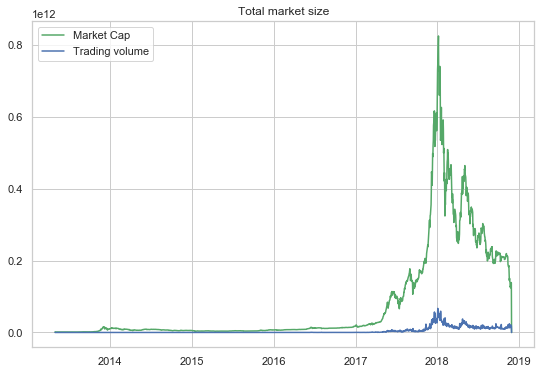

In [15]:
sns.set(style="whitegrid")
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title('Total market size')
sns.lineplot(data=crypto_market.market, color="g", label='Market Cap')
sns.lineplot(data=crypto_market.volume, color="b", label='Trading volume')

####  The top 5 competitors are relatively stable over time. They emerge from earlier 2014 to 2017. Bitcoin is leading the market, ripple recently surpasses ethereum to be at the second place.

In [16]:
crypto_3 = crypto[(crypto.ranknow <= 3)]
crypto_5 = crypto[(crypto.ranknow <= 5)]

Text(0.5,1,'Top 5 market competitors')

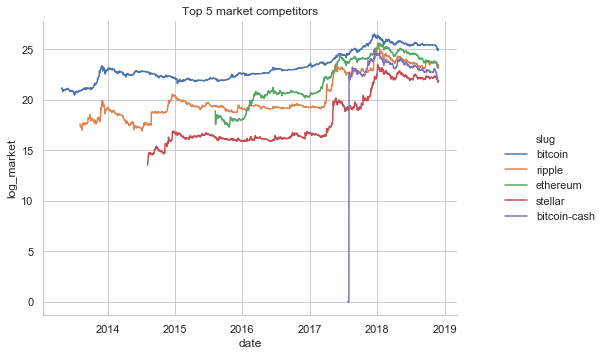

In [17]:
g = sns.relplot(x = 'date', y = 'log_market', kind = 'line', data = crypto_5, hue = 'slug')
g.fig.set_figwidth(9)
g.ax.set_title("Top 5 market competitors")

####  Take a snap shot of market on 2018-11-29, then we can summarize the market composition (ratio of market value of one currecy to the whole market cap)

In [18]:
crypto_snap = crypto[crypto.date == datetime(2018,11,29)]

In [19]:
crypto_snap.sort_values('ranknow', ascending=True).head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
2041,bitcoin,BTC,Bitcoin,2018-11-29,1,4269.000000,4413.020000,4145.770000,4278.850000,6.503348e+09,7.445102e+10,0.4980,0.062458,8.361440,22.595583,25.033407,-0.005021,2042
3985,ripple,XRP,XRP,2018-11-29,2,0.391862,0.392465,0.373789,0.379562,6.299006e+08,1.530674e+10,0.3091,0.049204,-0.968737,20.261073,23.451559,0.028556,1944
5196,ethereum,ETH,Ethereum,2018-11-29,3,122.720000,123.230000,115.300000,117.540000,2.196099e+09,1.216629e+10,0.2825,0.067466,4.766779,21.509949,23.221934,0.040842,1211
6774,stellar,XLM,Stellar,2018-11-29,4,0.161831,0.172107,0.155423,0.165080,8.886206e+07,3.162026e+09,0.5788,0.101066,-1.801325,18.302596,21.874479,-0.017372,1578
7269,bitcoin-cash,BCH,Bitcoin Cash,2018-11-29,5,190.100000,191.150000,176.830000,180.980000,8.916690e+07,3.164359e+09,0.2898,0.079125,5.198387,18.306020,21.875216,0.049006,495


In [20]:
crypto_snap['composition'] = np.where(crypto_snap.ranknow <= 10, crypto_snap.ranknow, 100)

In [21]:
crypto_mkt_comp = crypto_snap.groupby(by = ['composition'])['market'].sum()

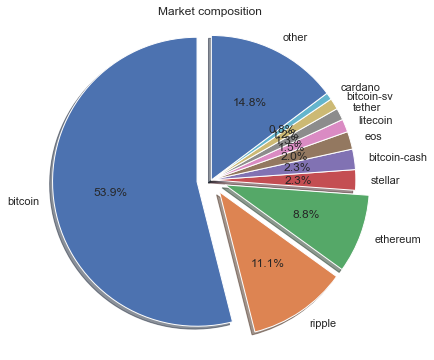

In [22]:
# Code reference:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = crypto_snap[crypto_snap.ranknow <= 11].slug.replace('monero', 'other')
sizes = crypto_mkt_comp
explode = (0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)  # only "explode" the first 3 slices

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Market composition')
ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## 2. Study the case of bitcoin 
###  Statistical pattern of return & size factor impact
###  Explore the statistical characteristics of daily log return, how can we model it with distribution? 
###  Are different currencies show similar pattern?

In [23]:
bitcoin = crypto[crypto.slug == 'bitcoin']

In [24]:
bitcoin.log_return.describe()

count    2042.000000
mean       -0.001695
std         0.043856
min        -0.357451
25%        -0.018403
50%        -0.001917
75%         0.012434
max         0.266198
Name: log_return, dtype: float64

In [25]:
## reference to code at the quant workshop
def plot_time_series(time_series):
    fig, (histo, qq) = plt.subplots(1, 2, figsize=(12, 4))
    histo.hist(time_series, bins = 20)
    histo.set_title('Distribution of time series')
    histo.set_xlabel('log return')
    histo.set_ylabel('frequency')
    stats.probplot(time_series, dist='norm', plot=plt)
    plt.show()

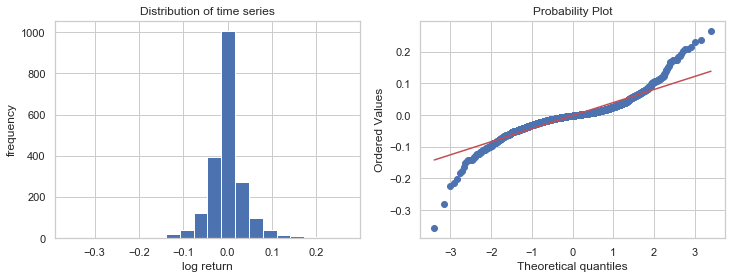

In [26]:
plot_time_series(bitcoin.log_return)

In [27]:
bitcoin_moment = [bitcoin.log_return.mean(), bitcoin.log_return.std(), bitcoin.log_return.skew(), bitcoin.log_return.kurtosis()]
pd.DataFrame(bitcoin_moment, columns = list(["Moments of bitcoin"]), index = list(["mean", "variance", "skewness", "kurtosis"]))

,Moments of bitcoin
mean,-0.001695
variance,0.043856
skewness,0.195551
kurtosis,7.940365


### Risk of Trading Bitcoin

- **VaR** measures the maximum loss in some extreme cases. For example, there is 5% chance an investor can lose 8.4% of his money in one day, assuming the log return of bitcoin follows normal distribution. 
- However, the actual chance of exceeding that loss in historical trading data is 6.12%, indicating the heavier tail for higher risk.
- **Maximum one day loss**: the worst trading day happened at 2013-12-18, when investor lost 35% in one day.
- **Maximum drawdown**: 

In [28]:
# VaR for bitcoin historical data
bitcoin_VaR = - (bitcoin_moment[0] - 1.96 * bitcoin_moment[1])
bitcoin_VaR

0.08765407242067674

In [29]:
# exceedence for bitcoin historical data
bitcoin_exceedence = bitcoin.log_return[abs(bitcoin.log_return - bitcoin_moment[0]) > 1.96 * bitcoin_moment[1]]
len(bitcoin_exceedence) / len(bitcoin.log_return) * 100

5.925563173359452

In [81]:
# max one day loss for bitcoin historical data
bitcoin[bitcoin.log_return == min(bitcoin.log_return)]

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
204,bitcoin,BTC,Bitcoin,2013-11-18,1,496.58,703.78,494.94,703.56,0.0,8.449070e+09,0.9989,0.296833,6.556153,0.0,22.857322,-0.357451,2042


In [31]:
# maximum drawdown for bitcoin historical data
n = len(bitcoin)
T = [0] * (1+n)
S = [0] * (1+n)
V = [0] * (1+n)
j = 0
for i in range(1,n+1,1) :
    # S[i] is the running sum up to i-th date
    # T[i] is the minimum running sum up to i-th date
    # V[j,i] is the maximum drawdown = S[i] - T[j]
    S[i] = S[i-1] + bitcoin.log_return[i-1]
    T[i] = max(T[i-1], S[i])
#     if V[i] < V[i-1]:
#         j+= 1
    V[i] = min(S[i] - T[i], V[i-1])

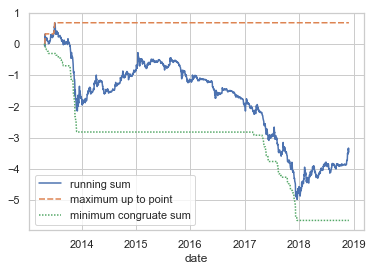

In [32]:
trading = pd.DataFrame(
    {'running sum': S[1:],
     'maximum up to point': T[1:],
     'minimum congruate sum': V[1:]
    }, index = bitcoin.date)

sns.lineplot(data= trading)
# from_date = j
# to_date = trading['minimum congruate sum'].argmin()
# print("Maximum drawdown is " + str(V[n]) + '%, from ' + + ' to ' + trading.index[to_date])

### Univariate Distribution, Time Series & Pairplot

Text(0.5,1,'log_market')

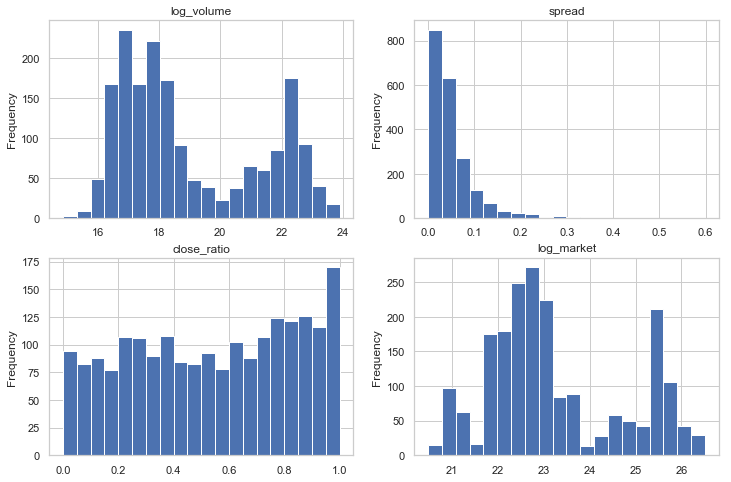

In [84]:
fig, axs = plt.subplots(2,2,figsize=(12, 8))
bitcoin['log_volume'][bitcoin['log_volume'] > 0].plot.hist(bins = 20, ax = axs[0,0]).set_title("log_volume")
bitcoin['spread'].plot.hist(bins = 20, ax = axs[0,1]).set_title("spread")
bitcoin['close_ratio'].plot.hist(bins = 20, ax = axs[1,0]).set_title("close_ratio")
bitcoin['log_market'].plot.hist(bins = 20, ax = axs[1,1]).set_title("log_market")

Text(0.5,1,'log_volume')

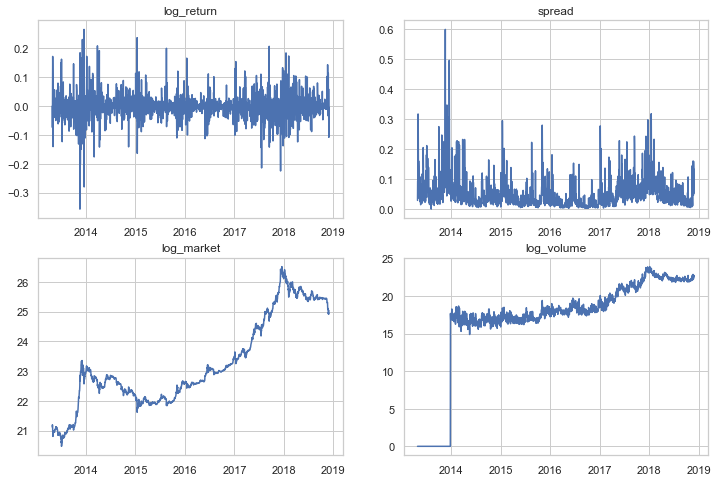

In [87]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))

ax1.plot(bitcoin.date, bitcoin.log_return)
ax1.set_title("log_return")
ax2.plot(bitcoin.date, bitcoin.spread)
ax2.set_title("spread")
ax3.plot(bitcoin.date, bitcoin.log_market)
ax3.set_title("log_market")
ax4.plot(bitcoin.date, bitcoin.log_volume)
ax4.set_title("log_volume")

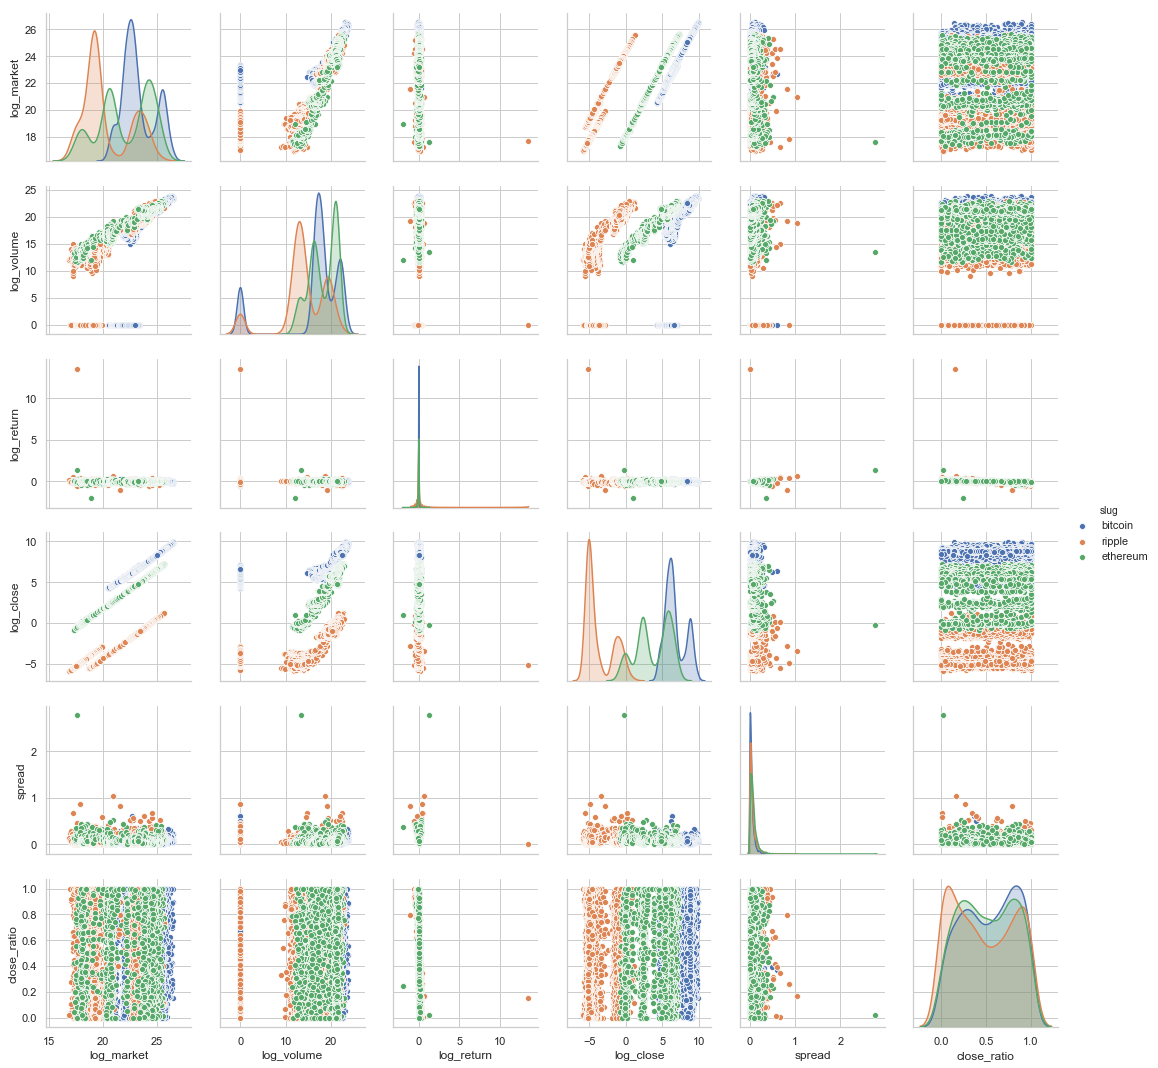

In [35]:
sns.pairplot(crypto_3[['slug','log_market','log_volume','log_return','log_close','spread','close_ratio']],hue="slug")

### Performance analysis - market size - the larger the better ?

#### Regression Analysis:
Model 1: $ log(return) = Cat (market size group ) + \epsilon $
- log(return) is the cross section return on 2018-11-29.

In [36]:
crypto_snap.log_market.describe()

count    2071.000000
mean       11.422279
std         5.529249
min         0.000000
25%        10.487206
50%        13.105313
75%        14.917343
max        25.033407
Name: log_market, dtype: float64

In [37]:
## discrization of market cap into groups
bins = [2,10,13,15,18,30]
crypto_snap['market_group'] = pd.cut(crypto_snap.log_market, bins)
crypto_snap['market_group'].value_counts()

(13, 15]    558
(10, 13]    556
(15, 18]    433
(2, 10]     124
(18, 30]     65
Name: market_group, dtype: int64

In [38]:
# large market cap currency and small market cap currency has a significant different in log return.
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [39]:
### Categorical variable for regression
model1 = smf.ols('log_return ~ C(market_group)', data=crypto_snap).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.974
Date:                Mon, 10 Dec 2018   Prob (F-statistic):             0.0184
Time:                        20:53:49   Log-Likelihood:                 142.83
No. Observations:                1736   AIC:                            -275.7
Df Residuals:                    1731   BIC:                            -248.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.0512      0.020      2.557      0.011       0.012       0.091
C(market_group)[T.Interval(10, 13, closed='right')]    -0.0391      0.022     -1.763      0.078      -0.083       0.004
C(market_group)[T.Interval(13, 15, closed='right')]    -0.0663      0.022     -2.991      0.003      -0.110      -0.023
C(market_group)[T.Interval(15, 18, closed='right')]    -0.0629      0.023     -2.766      0.006      -0.107      -0.018
C(market_group)[T.Interval(18, 30, closed='right')]    -0.0533      0.034     -1.559      0.119      -0.120       0.014
==============================================================================
Omnibus:                     1558.187   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373094.088
Skew:                          -3.444   Prob(JB):                         0.00
Kurtosis:                      74.488   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
crypto2017 = crypto[crypto.date.dt.year >= 2017]

In [41]:
# problem when market = 0
# slug : veritaseum
# date : 2017-6-11
# crypto2017[crypto2017.slug == "veritaseum"].head()

In [42]:
crypto2017 = crypto2017[crypto2017['market'] > 0]

In [43]:
crypto_mean = pd.DataFrame(crypto2017.groupby('slug').mean())

In [44]:
crypto_snap_group = pd.merge(crypto_mean, pd.DataFrame(crypto_snap[['slug','composition','market_group']]), how='inner', on = 'slug')

Model 2: $ log(return) = Cat (market size group ) + \epsilon $ 
- log(return) is the average over period 2017-01-01 to 2018-11-30.

In [45]:
model2 = smf.ols('log_return ~ C(market_group)', data=crypto_snap_group).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.841
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.84e-05
Time:                        20:53:49   Log-Likelihood:                 4447.1
No. Observations:                1736   AIC:                            -8884.
Df Residuals:                    1731   BIC:                            -8857.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.0102      0.002      6.086      0.000       0.007       0.014
C(market_group)[T.Interval(10, 13, closed='right')]    -0.0019      0.002     -1.022      0.307      -0.006       0.002
C(market_group)[T.Interval(13, 15, closed='right')]    -0.0035      0.002     -1.901      0.057      -0.007       0.000
C(market_group)[T.Interval(15, 18, closed='right')]    -0.0066      0.002     -3.469      0.001      -0.010      -0.003
C(market_group)[T.Interval(18, 30, closed='right')]    -0.0098      0.003     -3.411      0.001      -0.015      -0.004
==============================================================================
Omnibus:                      958.607   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171034.042
Skew:                          -1.496   Prob(JB):                         0.00
Kurtosis:                      51.534   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Performance Spectrum

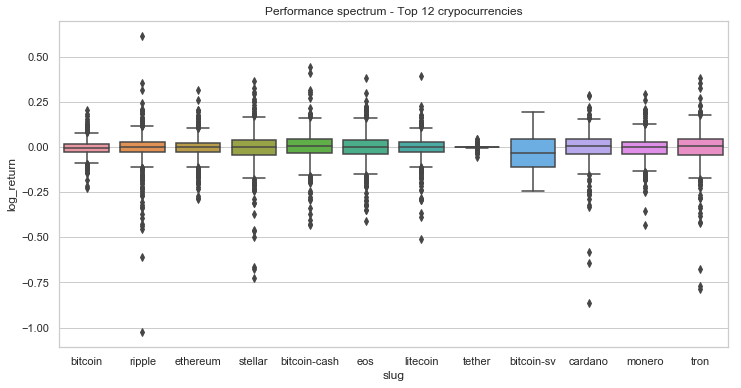

In [79]:
fig, ax = plt.subplots(figsize= (12,6))
ax.set_title('Performance spectrum - Top 12 crypocurrencies')
sns.boxplot('slug', 'log_return', data = crypto2017[crypto2017.ranknow <= 12], ax = ax)

## 3. Real assets v.s. virtual assets, correlation and dynamics

In [47]:
bitcoin2017 = crypto2017[crypto2017.slug == 'bitcoin']
ethereum2017 = crypto2017[crypto2017.slug == 'ethereum']
ripple2017 = crypto2017[crypto2017.slug == 'ripple']

In [48]:
virtual_asset = pd.DataFrame(columns =[], index = bitcoin2017.date)
virtual_asset = pd.merge(virtual_asset, bitcoin2017[['date', 'log_return']], how='inner', left_on = 'date', right_on = 'date')
virtual_asset = pd.merge(virtual_asset, ethereum2017[['date', 'log_return']], how='inner', left_on = 'date', right_on = 'date')
virtual_asset = pd.merge(virtual_asset, ripple2017[['date', 'log_return']], how='inner', left_on = 'date', right_on = 'date')
virtual_asset.columns = ['Date','bitcoin', 'ethereum', 'ripple']

In [49]:
virtual_asset.set_index('Date').head()

,bitcoin,ethereum,ripple
Date,,,
2017-01-01,-0.035262,-0.024784,0.012640
2017-01-02,-0.023188,-0.025379,0.008991
2017-01-03,-0.021389,-0.149366,-0.011814
2017-01-04,-0.100960,-0.145154,-0.028406
2017-01-05,0.130575,0.093090,0.057803


In [50]:
from datetime import datetime
start = datetime(2017, 1, 1)
end = datetime(2018, 11, 30)

In [51]:
# GOLD PRICE
import quandl
quandl.ApiConfig.api_key = 'jou3Hy9N_sKPZxy9mgxt'
gold_price = quandl.get("LBMA/GOLD", start_date = start, end_date = end)
gold_price.tail()

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2018-11-26,1226.65,1223.40,954.58,952.54,1079.33,1077.57
2018-11-27,1225.05,1221.20,959.70,958.76,1082.21,1080.76
2018-11-28,1213.20,1213.25,949.69,949.00,1074.77,1075.79
2018-11-29,1226.45,1226.25,959.94,960.03,1079.15,1077.87
2018-11-30,1220.45,1217.55,956.95,955.65,1073.75,1074.00


In [52]:
# S&P 500 INDEX 
from pandas_datareader import data
stock_index = data.DataReader('^GSPC', 'yahoo', start, end)
stock_index.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-11-26,2674.350098,2649.969971,2649.969971,2673.449951,3443950000,2673.449951
2018-11-27,2682.530029,2655.889893,2663.750000,2682.169922,3485220000,2682.169922
2018-11-28,2744.000000,2684.379883,2691.449951,2743.790039,3951670000,2743.790039
2018-11-29,2753.750000,2722.939941,2736.969971,2737.800049,3560770000,2737.800049
2018-11-30,2760.879883,2732.760010,2737.760010,2760.169922,4658580000,2760.169922


In [53]:
# DOLLAR INDEX 
USD_index = data.DataReader('DX-Y.NYB', 'yahoo', start, end)
USD_index.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-11-26,97.099998,96.660004,96.930000,97.070000,0.0,97.070000
2018-11-27,97.500000,96.970001,97.029999,97.370003,0.0,97.370003
2018-11-28,97.540001,96.690002,97.370003,96.790001,0.0,96.790001
2018-11-29,97.010002,96.629997,96.849998,96.779999,0.0,96.779999
2018-11-30,97.309998,96.709999,96.760002,97.269997,0.0,97.269997


In [54]:
real_asset = pd.merge(gold_price, stock_index, how = 'inner', on = 'Date')
real_asset = pd.merge(real_asset, USD_index, how = 'inner', on = 'Date')
real_asset = real_asset[['USD (AM)', 'Adj Close_x', 'Adj Close_y']]
real_asset.columns = ['Gold_Price', 'Stock_Index', 'USD_Index']

In [55]:
real_asset.tail()

,Gold_Price,Stock_Index,USD_Index
Date,,,
2018-11-26,1226.65,2673.449951,97.070000
2018-11-27,1225.05,2682.169922,97.370003
2018-11-28,1213.20,2743.790039,96.790001
2018-11-29,1226.45,2737.800049,96.779999
2018-11-30,1220.45,2760.169922,97.269997


In [56]:
for col in real_asset.columns:
    real_asset[col] = np.log(real_asset[col] / real_asset[col].shift(1))
    
real_asset.tail()

,Gold_Price,Stock_Index,USD_Index
Date,,,
2018-11-26,0.003675,0.015413,0.001546
2018-11-27,-0.001305,0.003256,0.003086
2018-11-28,-0.009720,0.022714,-0.005974
2018-11-29,0.010862,-0.002185,-0.000103
2018-11-30,-0.004904,0.008138,0.005050


In [57]:
six_assets = pd.merge(virtual_asset, real_asset, how='inner', on = 'Date')
six_assets.tail()

,Date,bitcoin,ethereum,ripple,Gold_Price,Stock_Index,USD_Index
469,2018-11-23,0.004322,0.027281,0.044763,-0.001513,-0.006576,0.002169
470,2018-11-26,0.059290,0.072280,0.052341,0.003675,0.015413,0.001546
471,2018-11-27,-0.010945,-0.015389,-0.013169,-0.001305,0.003256,0.003086
472,2018-11-28,-0.108224,-0.107050,-0.081017,-0.009720,0.022714,-0.005974
473,2018-11-29,-0.005021,0.040842,0.028556,0.010862,-0.002185,-0.000103


### Heatmap for correlation

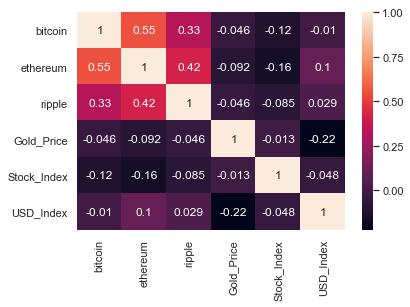

In [58]:
corr_matrix = six_assets.corr()
sns.heatmap(corr_matrix, annot = True)

### Regression to explain dynamics of bitcoin price

In [59]:
# a weak model
model3 = smf.ols('bitcoin ~ Gold_Price + Stock_Index + USD_Index', data=six_assets).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bitcoin   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.712
Date:                Mon, 10 Dec 2018   Prob (F-statistic):             0.0445
Time:                        20:53:55   Log-Likelihood:                 751.38
No. Observations:                 473   AIC:                            -1495.
Df Residuals:                     469   BIC:                            -1478.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0014      0.002     -0.619      0.536      -0.006       0.003
Gold_Price     -0.4170      0.365     -1.143      0.254      -1.134       0.300
Stock_Index    -0.8115      0.308     -2.631      0.009      -1.417      -0.205
USD_Index      -0.3659      0.617     -0.593      0.554      -1.579       0.847
==============================================================================
Omnibus:                       36.113   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.351
Skew:                          -0.014   Prob(JB):                     1.84e-34
Kurtosis:                       5.807   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4. Select currencies with best performances - Machine Learning - Clustering & PCA

### 4.1 Feature engineering and extraction

Inputs:
- The dataset is like panel data, we have many Crypto tokens and multi-dimensional data involving measurements over time. It is possible to either take a snapshot to use cross sectional data on a certain date, or I choose to use the average price or return information over time window from 2017 up to now.(Nov 30, 2018).
- Average of close_ratio, spread, log_market, log_close, log_volume.
- Moments of price: mean, standard deviation, skewness, kurtosis of crypto returns, instead of using open, close, high, low.
- Also notice the wired behavior when there is trading price but market is zero, for example, for slug veritaseum on date 2017-6-11, I decide to discard the first few trading days(?) when there is price but market is zero.

In [60]:
crypto2017.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
count,595238.000000,5.952380e+05,5.952380e+05,5.952380e+05,5.952380e+05,5.952380e+05,5.952380e+05,595238.000000,595238.000000,595238.000000,595238.000000,595238.000000,595238.000000,595238.000000
mean,902.305333,4.658370e+02,5.445852e+02,4.007423e+02,4.639630e+02,1.347123e+07,2.577568e+08,0.467447,0.248625,-3.020493,9.517809,14.672578,0.002463,776.299779
std,543.206972,1.578348e+04,1.930277e+04,1.324945e+04,1.572415e+04,2.312951e+08,4.485329e+09,0.316437,3.771033,3.384964,4.177720,2.816939,0.211420,528.704725
min,1.000000,1.100000e-08,2.400000e-08,5.700000e-09,1.100000e-08,0.000000e+00,3.000000e+00,0.000000,0.000000,-18.325371,0.000000,1.098612,-15.185294,9.000000
25%,403.000000,6.776000e-03,7.601000e-03,6.055000e-03,6.750250e-03,6.990000e+02,3.278428e+05,0.183400,0.089195,-4.998176,6.549651,12.700289,-0.051087,369.000000
50%,915.000000,4.889850e-02,5.420100e-02,4.397100e-02,4.871600e-02,1.650700e+04,2.661575e+06,0.444900,0.155348,-3.021748,9.711540,14.794429,0.004157,565.000000
75%,1402.000000,3.701320e-01,4.079625e-01,3.352648e-01,3.691550e-01,2.843362e+05,1.561490e+07,0.742100,0.270866,-0.996539,12.557913,16.563736,0.065228,1176.000000
max,2039.000000,2.298390e+06,2.926100e+06,2.030590e+06,2.300740e+06,2.384090e+10,3.265025e+11,1.000000,2430.985612,14.648741,23.894668,26.511703,10.112565,2042.000000


In [61]:
# Code Reference:
# https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html 
# Python Data Science Handbook by Jake VanderPlas - Aggregation and Grouping
crypto_2017_log_return = crypto2017.groupby('slug').log_return

ret_mean = pd.DataFrame(crypto_2017_log_return.mean())
ret_std = pd.DataFrame(crypto_2017_log_return.std())
ret_skew = pd.DataFrame(crypto_2017_log_return.skew())
ret_kurt = pd.DataFrame(crypto_2017_log_return.apply(pd.DataFrame.kurt))

ret_mean.columns = ['mean']
ret_std.columns = ['std']
ret_skew.columns = ['skew']
ret_kurt.columns = ['kurt']

df = pd.merge(crypto_mean, ret_mean, on = 'slug')
df = pd.merge(df, ret_std, on = 'slug')
df = pd.merge(df, ret_skew, on = 'slug')
df = pd.merge(df, ret_kurt, on = 'slug')
df.dropna(inplace = True)

In [62]:
df.sort_values('ranknow').head()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time,mean,std,skew,kurt
slug,,,,,,,,,,,,,,,,,,
bitcoin,1,5879.437479,6063.117980,5670.512206,5883.713438,4.166287e+09,9.937140e+10,0.560631,0.059213,8.404334,21.547487,25.037688,-0.002136,2042,-0.002136,0.046586,0.127863,3.088802
ripple,2,0.438744,0.464717,0.411817,0.439343,5.504764e+08,1.714795e+10,0.493710,0.098064,-1.523831,18.788558,22.854042,-0.005838,1944,-0.005838,0.094677,-2.543051,26.824691
ethereum,3,364.897579,379.184570,348.321017,364.924470,1.472782e+09,3.563600e+10,0.534083,0.079504,5.416638,20.420479,23.797372,-0.003855,1211,-0.003855,0.064230,-0.287972,3.598397
stellar,4,0.160354,0.169826,0.150213,0.160550,6.672434e+07,2.916303e+09,0.499450,0.125605,-2.850370,16.646575,20.518061,-0.006021,1578,-0.006021,0.099679,-1.742224,11.438352
bitcoin-cash,5,931.378230,988.645288,873.769239,930.856481,7.681712e+08,1.582737e+10,0.472779,0.112429,6.648604,20.082223,23.298961,0.001002,495,0.001002,0.092247,-0.471956,5.545678


In [63]:
# use the top 100 crypto for clear demonstration
df100 = df[df.ranknow <= 100][['close_ratio', 'spread', 'log_market', 'log_volume', 'log_close', 'survival_time', 
                               'mean','std', 'skew', 'kurt']]

In [64]:
from sklearn.preprocessing import scale
data = scale(df100)
type(data)

numpy.ndarray

In [65]:
data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### 4.2 K-means clustering 
#### -Group 2,071 crypto currencies into a few clusters

In [66]:
from sklearn.cluster import KMeans

#### Tune parameter - number of cluster centers

In [67]:
np.random.seed(0)
inertia = []
for i in range(2,16,1):
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10)
    inertia.append(kmeans.fit(data).inertia_)

In [90]:
n = 2071
np.sqrt(n/2)

32.179185819408175

In [68]:
from sklearn import metrics
silhouttescore = []
for i in range(2,16,1):
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10).fit(data)
    silhouttescore.append(metrics.silhouette_score(data, kmeans.labels_))

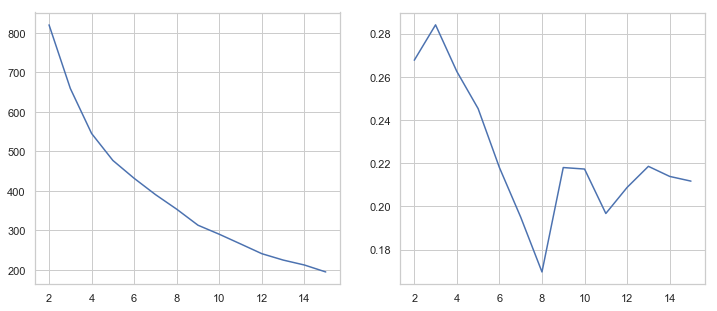

In [69]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x = range(2,16,1), y = inertia, markers = "o", ax=axs[0])
sns.lineplot(x = range(2,16,1), y = silhouttescore, markers = "b*-", ax=axs[1])

#### n_cluster = 3.

In [71]:
cluster_labels = pd.DataFrame(kmeans.labels_, index = df100.index, columns = ['label'])
df_cluster = pd.merge(df100, cluster_labels, on = 'slug')

In [92]:
model5 = smf.ols('mean ~ C(label)', data=df_cluster).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     161.7
Date:                Tue, 11 Dec 2018   Prob (F-statistic):           1.29e-31
Time:                        19:17:40   Log-Likelihood:                 383.77
No. Observations:                 100   AIC:                            -761.5
Df Residuals:                      97   BIC:                            -753.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0012      0.001      1.922      0.058   -3.77e-05       0.002
C(label)[T.1]     0.0927      0.005     17.405      0.000       0.082       0.103
C(label)[T.2]    -0.0047      0.001     -3.613      0.000      -0.007      -0.002
==============================================================================
Omnibus:                       27.843   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.407
Skew:                          -0.882   Prob(JB):                     1.73e-19
Kurtosis:                       7.198   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.3 Dimension Reduction and Exploratory Factor Analysis(EFA)

### Multidimensional Scaling (MDS)

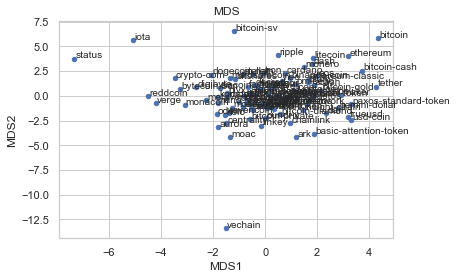

In [73]:
# Code Reference: Lab 10 Dimension Reduction

# Use MDS to visualize brands.
# Recall that df_bybrand is the mean-metric-by-brand 
# we created above.
import sklearn.manifold as skm
X = skm.MDS(n_components=2).fit_transform(data)
plt.scatter(X[:,0],X[:,1],s=20)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df100.index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=10)

### Principal Component Analysis (PCA)

In [74]:
import sklearn.decomposition as skd
# build a PCA model with 3 components
pca_model = skd.PCA(n_components=3).fit(data)

# Show the principcal components
df_pca = pd.DataFrame(pca_model.components_[:3,:].T, 
             index=df100.columns,
             columns=['PC1', 'PC2', 'PC3'])
df_pca

,PC1,PC2,PC3
close_ratio,0.362649,0.046433,0.181602
spread,-0.148762,-0.159618,0.444917
log_market,0.474455,0.342537,0.060864
log_volume,0.453297,0.329673,0.006709
log_close,0.372170,0.091439,-0.259165
survival_time,0.302720,-0.075458,0.183502
mean,-0.320541,0.562546,-0.144945
std,-0.242313,0.549529,0.313442
skew,-0.146615,0.272947,-0.466163
kurt,-0.051590,0.198379,0.572641


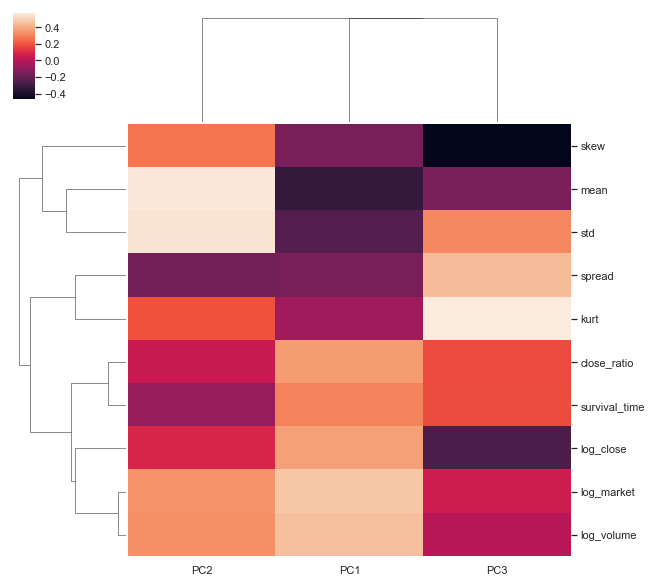

In [75]:
# Visualize the factor loading matrix
sns.clustermap(df_pca)

### Factor Analysis (EFA)

In [76]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3).fit(data)

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T,
                           index=df100.columns,
                           columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
close_ratio,-0.195974,0.379632,0.326514
spread,-0.002146,0.616834,-0.375464
log_market,0.001539,0.213437,0.901515
log_volume,-0.039086,0.166048,0.815570
log_close,-0.211597,-0.065506,0.496340
survival_time,-0.223413,0.308666,0.266459
mean,0.940915,-0.322996,0.022946
std,0.907484,0.405118,-0.023163
skew,0.347081,-0.311811,0.005738
kurt,0.241878,0.430511,-0.025334


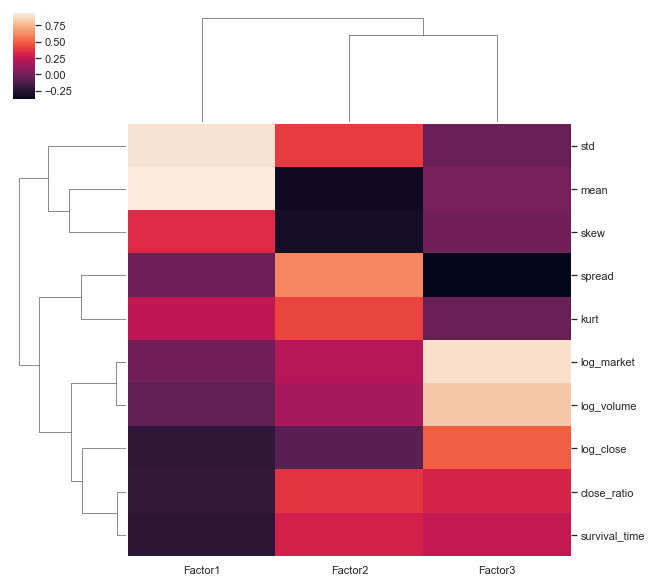

In [77]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings)